In [ ]:
# Sentinel-2 data acess

# Sentinel-2 data access API OpenEO
# https://openeo.org/

# You need an account with Copernicus to access the satellite image data
# https://dataspace.copernicus.eu/

# Dec 2024

In [ ]:
import os, sys, time, random, itertools, shutil
from google.colab import drive

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# variables specific to your CoLabsetup ----------------------------------------
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/research/'
#place the custom-built python routines in the 'code' directory
sys.path.append(root +'code/')

#set your data paths as appropriate
datapath = root + "data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install packages
%%capture
!pip install openeo --upgrade
!pip install geojson --upgrade
!pip install rasterio --upgrade
!pip install earthpy --upgrade

In [ ]:
# prebuilt imports
import openeo
from osgeo import gdal
import json
import rasterio
import numpy
import PIL
import time, random, itertools, shutil, folium

In [ ]:
# custom imports
from utilities import *
from kmeans_module import *
from openeo_helper import initialize, create_job
from quality_check import recompile, filter

In [ ]:
# Import necessary modules
from ipyleaflet import Map, Marker
from ipywidgets import Output

# Step 3: Create a global variable to store lat/lon and marker
selected_coords = None
markers = []
interaction_enabled = True
# Step 4: Create an output widget to display selected lat/lon
output = Output()

# Step 5: Define a function that will handle map clicks only
def handle_click(**kwargs):
    global selected_coords, markers, interaction_enabled
    if kwargs.get('type') == 'click':  # Check if the event is a click
        coordinates = kwargs.get('coordinates')
        if interaction_enabled and coordinates:
            # mymap.clear_layers()
            selected_coords = coordinates

            # Step 6: Create a marker at the clicked location
            marker = Marker(location=coordinates)

            # Step 7: Add the marker to the map
            mymap.add(marker,index=1)
            # Optional: Store the marker in a list if you want to manage or remove it later
            # print(mymap.layers)
            markers= [marker]

            # Step 8: Display the coordinates in the output widget
            with output:
                output.clear_output()
                print(f"Latitude: {coordinates[0]}, Longitude: {coordinates[1]}")

            interaction_enabled = False

# Step 9: Create a map centered at a default location
mymap = Map(center=(20, 0), zoom=2)

# Step 10: Add a click event listener to the map
mymap.on_interaction(handle_click)

# Step 11: Display the map and the output widget for lat/lon
display(mymap, output)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Output()

In [ ]:
latitude, longitude = selected_coords
bbox = get_coordinates(latitude,longitude,surface_area=100)
print(bbox)

[-81.29184205369523, 33.46973888898748, -81.18408851038308, 33.37980672839561]


In [ ]:
# connect to the cdse backend with your user name and password
copernicus_url = "openeo.dataspace.copernicus.eu"
connection = openeo.connect(copernicus_url)

#authenticate with your Copernicus credentials
connection.authenticate_oidc()
print()

Authenticated using refresh token.



In [ ]:
# set the openEO inputs
# L1C data is radiometrically corrected, while L2A data is atmospherically corrected
# The Level-2A processing includes a scene classification and an atmospheric
# correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products.
# Level-2A main output is an orthoimage Bottom-Of-Atmosphere (BOA) corrected reflectance product

satellite = "SENTINEL2_L2A"
#satellite = "SENTINEL2_L1C"
max_cloud = 15
start = "2024-10-01"
end = "2024-12-12"
#band_selection = ["B04", "B03", "B02"] #RGB, TCI
band_selection = ["B08", "B04", "B03", "B02"] #IR R G B

In [ ]:
job = create_job(connection, bbox, start, end, satellite, band_selection, max_cloud)

In [ ]:
print(connection.list_jobs())

[{'created': '2024-12-12T19:03:54Z', 'id': 'j-241212b462f94a4cb832f221c3c3f44f', 'progress': 0, 'status': 'created', 'title': 'testing', 'updated': '2024-12-12T19:03:54Z'}, {'created': '2024-12-12T19:01:16Z', 'id': 'j-2412128b11f14ceeba863fc9cc1aa73e', 'progress': 0, 'status': 'created', 'title': 'testing', 'updated': '2024-12-12T19:01:16Z'}, {'created': '2024-12-12T18:45:23Z', 'id': 'j-241212b8469d458ab16dd799d4f674aa', 'progress': 100, 'status': 'finished', 'title': 'testing', 'updated': '2024-12-12T18:47:07Z'}, {'created': '2024-12-12T18:38:22Z', 'id': 'j-2412122dac3b430c98a5123ee218982b', 'status': 'error', 'title': 'testing', 'updated': '2024-12-12T18:40:12Z'}, {'created': '2024-12-12T18:35:32Z', 'id': 'j-241212e829bb4bbf85fbe97b08d86638', 'status': 'error', 'title': 'testing', 'updated': '2024-12-12T18:37:08Z'}, {'created': '2024-12-12T18:29:58Z', 'id': 'j-2412129a4b6a45c3af55d8b5c90db18f', 'status': 'error', 'title': 'testing', 'updated': '2024-12-12T18:32:05Z'}, {'created': '20

In [ ]:
try:
    job.start_and_wait()
except:
    print("something went wrong")

0:00:00 Job 'j-241212b462f94a4cb832f221c3c3f44f': send 'start'
0:00:24 Job 'j-241212b462f94a4cb832f221c3c3f44f': created (progress 0%)
0:00:29 Job 'j-241212b462f94a4cb832f221c3c3f44f': created (progress 0%)
0:00:35 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:00:44 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:00:54 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:01:06 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:01:22 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:01:41 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:02:05 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:02:35 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:03:13 Job 'j-241212b462f94a4cb832f221c3c3f44f': running (progress N/A)
0:04:00 Job 'j-241212b462f94a4cb832f221c3c3f44f': finished (progress 100%)


In [ ]:
results = job.get_results()
rt = results.get_assets()
print("Found this number of items: ", str(len(rt)))

for item in rt:
    print(item)

print("Click on an single link to download only that file or proceed to the next cell...")

Found this number of items:  14
<ResultAsset 'openEO_2024-10-02Z.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjNjI3YjktMWQxNS00NDZlLWE4NDMtOWU3ZWIzYjExMDhh/fbccda02ff9a2030c67721bdaffefc17/openEO_2024-10-02Z.tif?expires=1734635444'>
<ResultAsset 'openEO_2024-10-07Z.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjNjI3YjktMWQxNS00NDZlLWE4NDMtOWU3ZWIzYjExMDhh/79937e7ccd2931b0530d018680bc26fa/openEO_2024-10-07Z.tif?expires=1734635444'>
<ResultAsset 'openEO_2024-10-12Z.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjNjI3YjktMWQxNS00NDZlLWE4NDMtOWU3ZWIzYjExMDhh/a2905a860433ed1e7bdbbc3cb7505483/openEO_2024-10-12Z.tif?expires=1734635444'>
<ResultAsset 'openEO_2024-10-14Z

In [ ]:
# early quality check
metadata = results.get_metadata()
compiled = recompile(metadata)
filtered_images = filter(compiled)

print(filtered_images)

['openEO_2024-10-14Z.tif', 'openEO_2024-10-19Z.tif', 'openEO_2024-10-24Z.tif', 'openEO_2024-11-13Z.tif', 'openEO_2024-11-23Z.tif', 'openEO_2024-12-03Z.tif']


In [ ]:
# download pruned collection
assets = rt
download_relevant_files(assets,filtered_images,selected_coords, datapath)

{'openEO_2024-10-14Z_33_81_1734030659.tif': <ResultAsset 'openEO_2024-10-14Z_33_81_1734030659.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjNjI3YjktMWQxNS00NDZlLWE4NDMtOWU3ZWIzYjExMDhh/87bddad6648589d0772a00b46b3c4fee/openEO_2024-10-14Z.tif?expires=1734635444'>,
 'openEO_2024-10-19Z_33_81_1734030662.tif': <ResultAsset 'openEO_2024-10-19Z_33_81_1734030662.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjNjI3YjktMWQxNS00NDZlLWE4NDMtOWU3ZWIzYjExMDhh/249f466286fdf40ef36f641793157dc0/openEO_2024-10-19Z.tif?expires=1734635444'>,
 'openEO_2024-10-24Z_33_81_1734030663.tif': <ResultAsset 'openEO_2024-10-24Z_33_81_1734030663.tif' (type image/tiff; application=geotiff) at 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-241212b462f94a4cb832f221c3c3f44f/results/assets/ZTJjN

Number of bands: 4


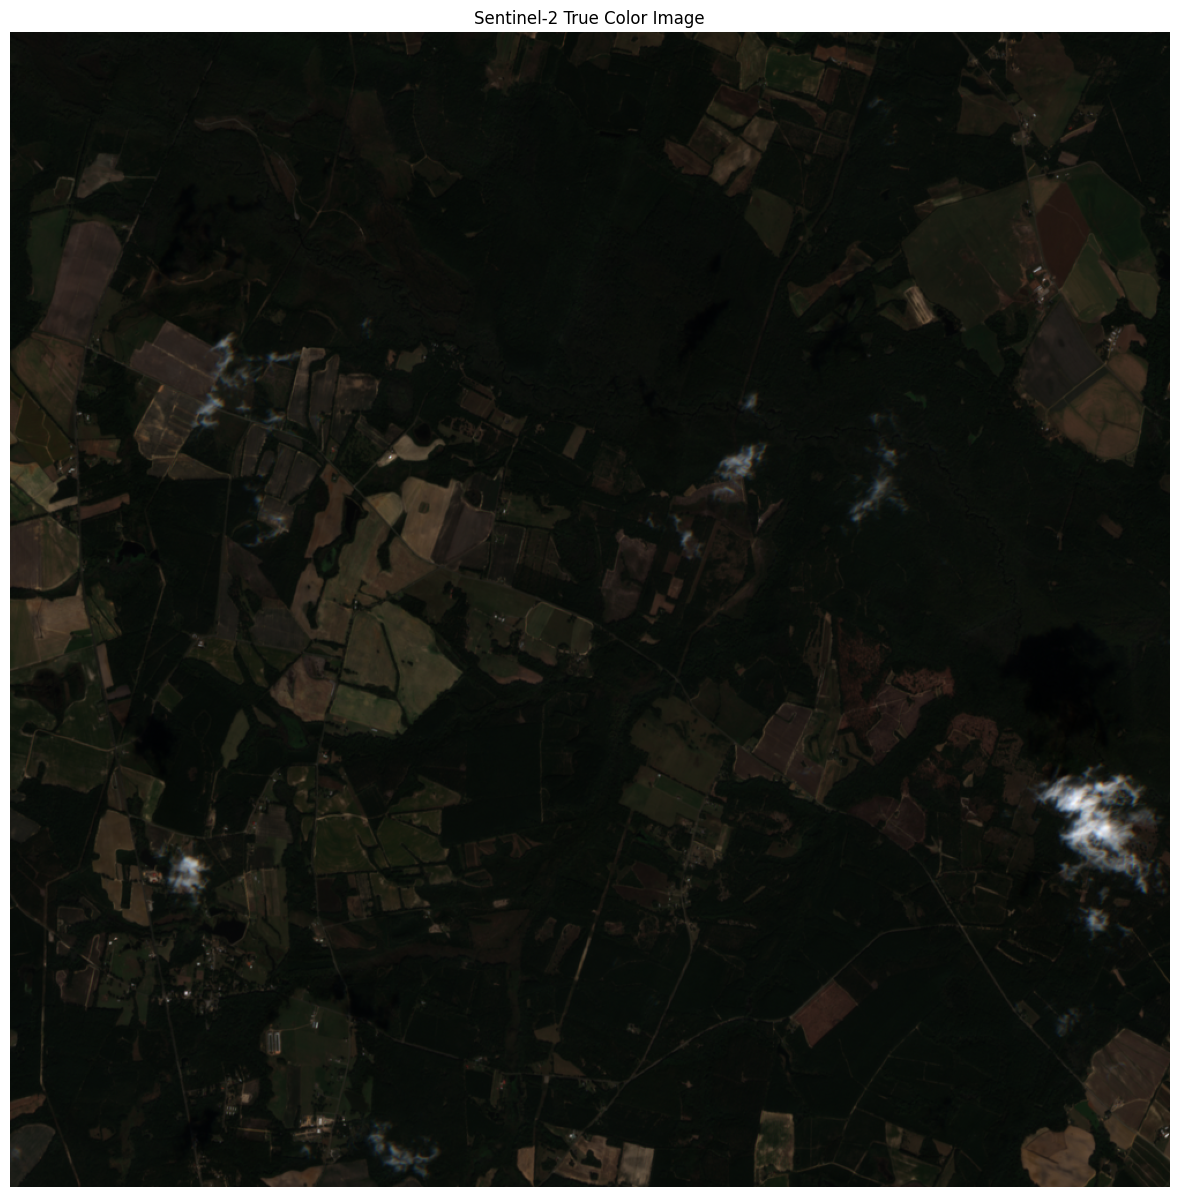

In [ ]:
import matplotlib.pyplot as plt
#1 - IR, 2-Red, 3-Green, 4-Blue (choose R, G, B to visualize)
sample = 'openEO_2024-10-14Z_33_81_1734030659.tif'
bands = [2,3,4]

rgb_processed = process_geotiff(sample, bands, datapath)
plt.figure(figsize=(15, 15))
plt.imshow(rgb_processed)
plt.title("Sentinel-2 True Color Image")
plt.axis('off')
plt.show()

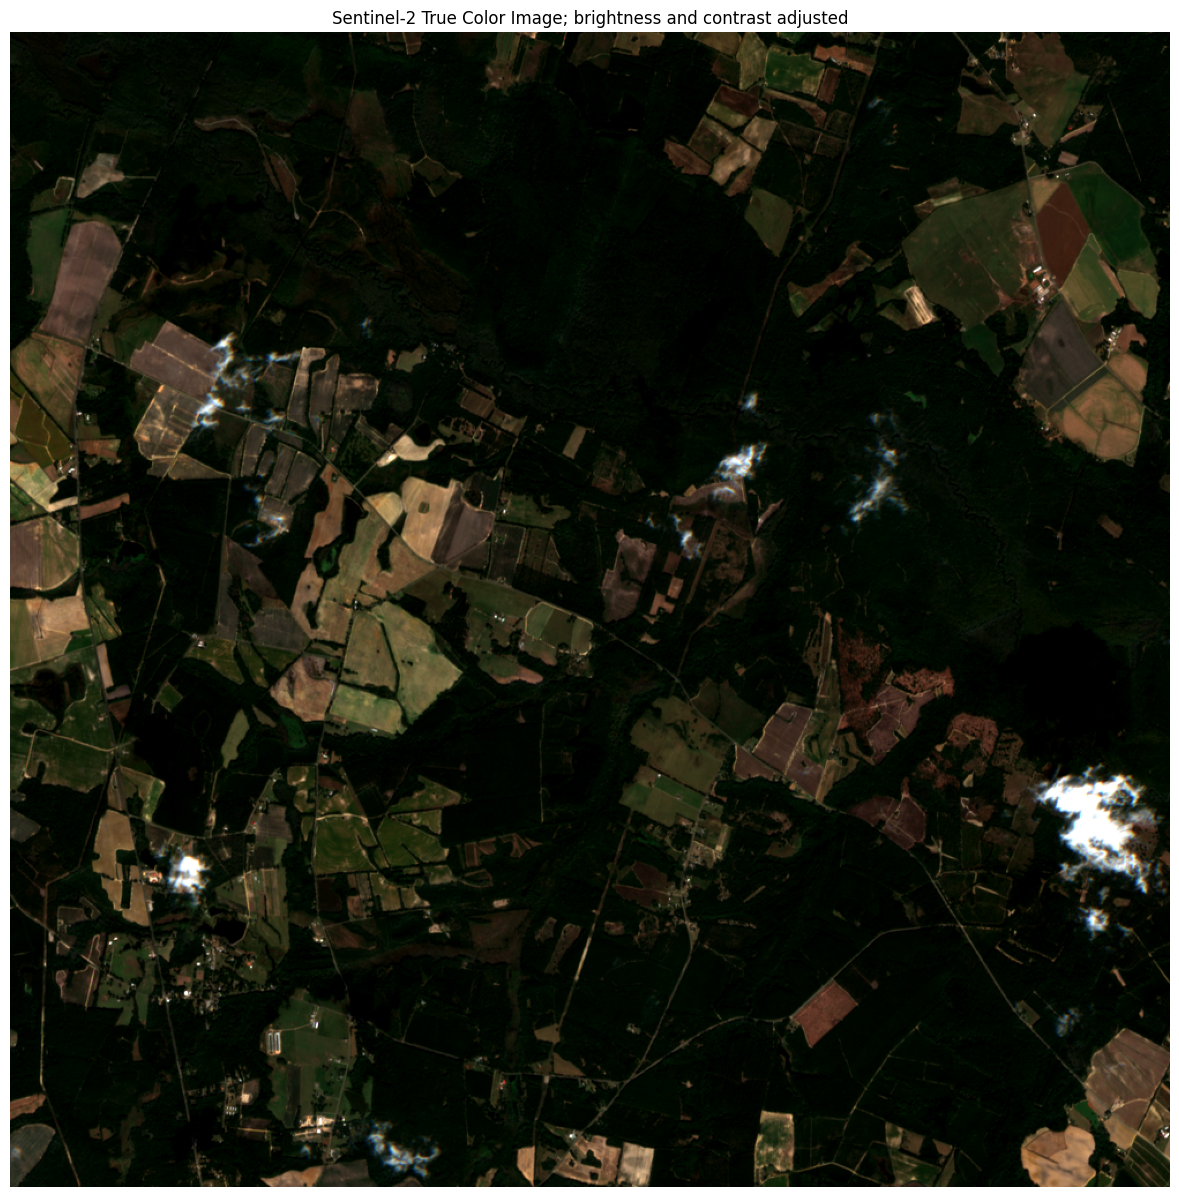

In [ ]:
# Adjust brightness and contrast of the color corrected image

brightness_factor = 2.1
contrast_factor = 1.2
dataset = rgb_processed

rgb_adjusted = adjust_brightness_contrast_npy(dataset, bands, brightness_factor, contrast_factor)

if rgb_adjusted is not None:
    plt.figure(figsize=(15, 15))
    plt.imshow(rgb_adjusted)
    plt.axis('off')
    plt.title("Sentinel-2 True Color Image; brightness and contrast adjusted")
    plt.show()
else:
    print("Failed to process the image.")

In [ ]:
# Convert to NPY

#input_tif = geoaipath + "openEO-sentinel2A_LA_2024-10-19Z.tif"
#output_npy = geoaipath + "openEO-sentinel2A_LA_2024-10-19Z.npy"

input_tif = datapath + "openEO_2024-10-19Z_Buffalo_IR+RGB.tif"
output_npy = datapath + "openEO_2024-10-19Z_Buffalo_IR+RGBZ.npy"

tif_to_numpy(input_tif, output_npy)

Successfully converted /content/drive/MyDrive/Colab/research/data/openEO_2024-10-19Z_Buffalo_IR+RGB.tif to NumPy array
Array shape: (4, 1025, 1028)
Saved to: /content/drive/MyDrive/Colab/research/data/openEO_2024-10-19Z_Buffalo_IR+RGBZ.npy


In [ ]:
# check the numpy dimensions.
# required:
# #bands x length x width (single image)
# #images x #bands x length x width (multi image)

output_npy = datapath + "openEO_2024-10-19Z_Buffalo_IR+RGBZ.npy"
loaded_array = numpy.load(output_npy)
print(loaded_array.shape)

# re-arrange if necessary
#rearranged_array = numpy.transpose(loaded_array, (2, 0, 1))
#rearranged_array = numpy.transpose(loaded_array, (1, 2, 0))
#print(rearranged_array.shape)
#numpy.save(output_npy_fix, rearranged_array)

(4, 1025, 1028)


Shape:  (4, 1025, 1028)


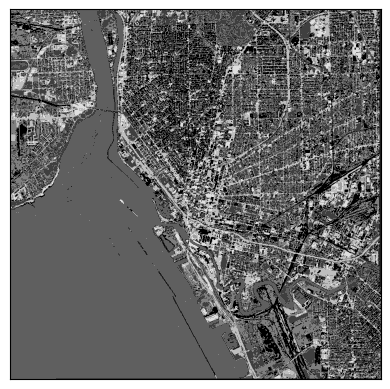

In [ ]:
# perform k-means check

path = datapath
iname = "openEO_2024-10-19Z_Buffalo_IR+RGBZ.npy"
loaded = numpy.load(path + iname)
print("Shape: ", loaded.shape)

kmeansname = iname.split('.npy')[0] + '_cluster.png'
stackname = path + iname

stack = numpy.load(stackname)
n_stack = 6 #6, 1
n_components = 4  #IR-RGB
#n_components = 3 #if RGB

#pick a number of clusters and coloring scheme
n_clusters = 9
do_gray = True

if(do_gray):
    colorlist = ['#%02x%02x%02x' % (i, i, i) for i in numpy.linspace(0, 255, n_clusters).astype(int)]
else:
    colorlist = ['#%02x%02x%02x' % (r, g, b) for r, g, b in numpy.random.randint(0, 255, size=(n_clusters, 3))]

perform_kmeans(stack, n_stack, n_components, n_clusters, colorlist, kmeansname)

In [ ]:
# perform RESNET152 classification
# 1-image input OR multi-iamge (8) input
